In [30]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
from scipy.sparse import save_npz
from scipy.sparse import load_npz
from datasketch import MinHash
from itertools import combinations
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from datasketch import MinHashLSH

In [3]:
# create a user_movie matrix

data = np.load('../../temp_data/user_movie_rating.npy')
data_array = data.astype(int)

# Extract user, movie, and rating data from the loaded records
user_ids, movie_ids, ratings = data[:, 0], data[:, 1], data[:, 2]

# Create a CSR 
user_movie_matrix = csr_matrix((ratings, (user_ids, movie_ids)))


# Load the user-movie ratings data from the npz file
num_users = user_movie_matrix.shape[0]
num_movies = user_movie_matrix.shape[1]

Bin 0 (1 users): [0]
Bin 1 (0 users): []
Bin 2 (0 users): []
Bin 3 (0 users): []
Bin 4 (0 users): []
Bin 5 (0 users): []
Bin 6 (2 users): [5609, 99983]
Bin 7 (8 users): [23599, 33742, 60037, 65441, 72820, 79259, 93556, 97796]
Bin 8 (55 users): [823, 2592, 4940, 5385, 8843, 21296, 22642, 23000, 24034, 24340, 31518, 32380, 32652, 32706, 33270, 33285, 33564, 33714, 34192, 34359, 35193, 40090, 40528, 42599, 44203, 46198, 47425, 53961, 57133, 60129, 60213, 61087, 66094, 69563, 71138, 72057, 72155, 72857, 76157, 78721, 79613, 79812, 79825, 79895, 84851, 86046, 86271, 87847, 90861, 91812, 92088, 93469, 94612, 97144, 100812]
Bin 9 (295 users): [29, 101, 703, 1148, 1707, 2171, 2187, 2931, 2963, 3084, 3457, 3542, 4170, 4464, 4778, 5284, 5407, 5532, 6137, 6635, 6977, 7113, 8600, 8951, 9061, 9294, 9633, 10671, 10775, 10829, 10903, 11012, 11526, 11529, 11532, 11922, 11974, 12616, 13143, 13269, 13305, 13493, 13529, 13616, 13650, 13740, 14227, 14718, 14788, 14839, 14903, 15687, 15728, 16785, 17288, 1

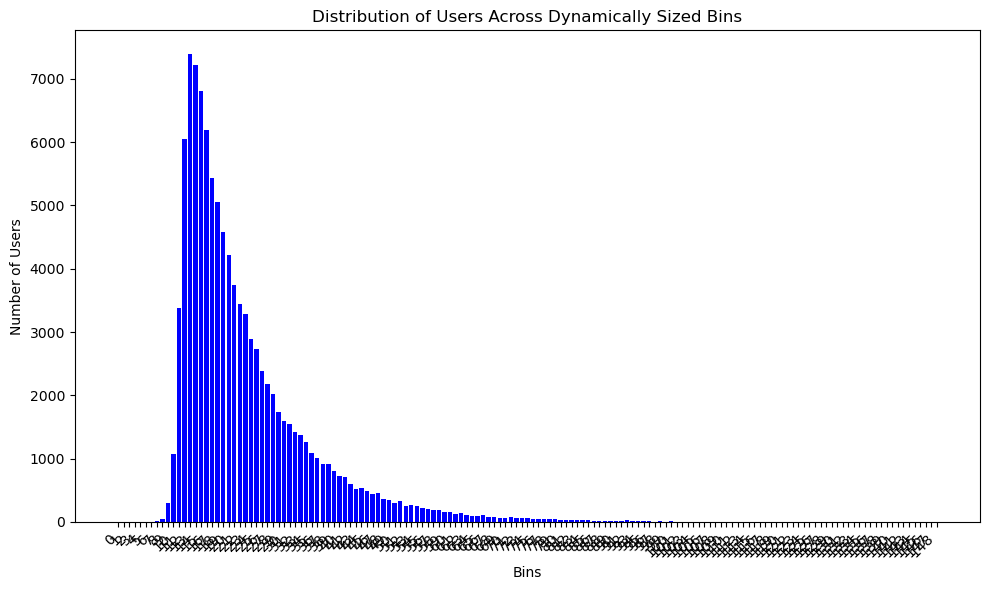

In [70]:
# binning using number of movies

# Get the number of rated movies for each user
num_rated_movies_per_user = np.asarray(user_movie_matrix.sum(axis=1)).flatten()

# Find the maximum number of ratings
max_ratings = num_rated_movies_per_user.max()

# Define the desired number of bins
num_bins = 20  # This can be adjusted based on the desired granularity

# Calculate the bin width to achieve approximately equal number of users in each bin
desired_bin_width = len(num_rated_movies_per_user) / num_bins
bin_width = 100

# Define bins with dynamically calculated width
bins = np.arange(0, max_ratings + bin_width, bin_width)

# Function to bin users based on the number of movies rated
def bin_users_by_ratings(num_rated_movies_per_user, bins):
    # Use np.digitize to find the indices of the bins to which each value belongs
    bin_indices = np.digitize(num_rated_movies_per_user, bins, right=True)
    
    # Group user_ids by the bin they belong to
    binned_users = {str(i): [] for i in range(len(bins))}
    for user_id, bin_index in enumerate(bin_indices):
        binned_users[str(bin_index)].append(user_id)
    
    return binned_users

# Bin the users
binned_users = bin_users_by_ratings(num_rated_movies_per_user, bins)

# Print the results
total_users = sum(len(users) for users in binned_users.values())

for bin_name, users in binned_users.items():
    print(f'Bin {bin_name} ({len(users)} users): {users}')

print(f'Total Users: {total_users}')

# Plotting the histogram
bin_names = list(binned_users.keys())
user_counts = [len(users) for users in binned_users.values()]

plt.figure(figsize=(10, 6))  # Adjust the figure size for better readability
plt.bar(bin_names, user_counts, color='blue')
plt.xlabel('Bins')
plt.ylabel('Number of Users')
plt.title('Distribution of Users Across Dynamically Sized Bins')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Adjust the layout to fit everything nicely
plt.show()




# Minhashing FOR JS

In [71]:
def create_minhash_signatures(user_movie_matrix, binned_users, num_permutations):
    # Create a dictionary to store the MinHash signatures for each bin
    minhash_signatures = {bin_name: [] for bin_name in binned_users}

    # Iterate over each bin
    for bin_name, user_indices in binned_users.items():
        # For each user in the bin
        for user_index in user_indices:
            # Get the non-zero indices (movie IDs) for the user's ratings
            # The toarray() is needed because user_movie_matrix is a sparse matrix
            movies_rated = user_movie_matrix[user_index, :].nonzero()[1]
            
            # Create a MinHash object
            m = MinHash(num_perm=num_permutations)
            # Update the MinHash object with the movie IDs
            for movie_id in movies_rated:
                m.update(str(movie_id).encode('utf8'))
            
            # Store the MinHash object in the corresponding bin
            minhash_signatures[bin_name].append(m)
    
    return minhash_signatures

num_permutations = 100  # The number of permutations in the MinHash
minhash_signatures = create_minhash_signatures(user_movie_matrix, binned_users, num_permutations)



In [72]:
def hash_users_into_buckets(minhash_signatures, num_permutations, threshold=0.3): # threshold for users to be put into bin
    # Define the LSH index for each bin
    lsh_indexes = {bin_name: MinHashLSH(threshold=threshold, num_perm=num_permutations) for bin_name in minhash_signatures}

    # A dictionary to store the mapping of users to buckets for each bin
    buckets = {bin_name: {} for bin_name in minhash_signatures}

    # Populate the LSH index and buckets for each bin
    for bin_name, minhashes in minhash_signatures.items():
        for user_index, minhash in enumerate(minhashes):
            # Add the user's MinHash to the LSH index
            lsh_indexes[bin_name].insert(f"user_{user_index}", minhash)
            # Query the LSH index for the bucket keys where the user was hashed
            bucket_keys = lsh_indexes[bin_name].query(minhash)
            # Store the user in the corresponding buckets
            for key in bucket_keys:
                if key not in buckets[bin_name]:
                    buckets[bin_name][key] = []
                buckets[bin_name][key].append(user_index)
    
    return buckets

# Example
num_permutations = 100  # The number of permutations in the MinHash
threshold = 0.5  # The Jaccard similarity threshold for LSH
buckets = hash_users_into_buckets(minhash_signatures, num_permutations, threshold)


In [73]:
from itertools import combinations

def compute_similarities_above_threshold(buckets, minhash_signatures, threshold=0.5):
    # A dictionary to store the pairs of users with Jaccard similarity above the threshold
    similar_users = {bin_name: {'pairs': [], 'count': 0} for bin_name in buckets}

    # For each bin
    for bin_name, bucket_dict in buckets.items():
        # For each bucket in the bin
        for bucket_key, user_indices in bucket_dict.items():
            # Compute all pairs of users within the bucket
            for user_index1, user_index2 in combinations(user_indices, 2):
                # Compute the Jaccard similarity between the two users' MinHash signatures
                jaccard_similarity = minhash_signatures[bin_name][user_index1].jaccard(minhash_signatures[bin_name][user_index2])
                # If the similarity is above the threshold, record the pair of users and increment the count
                if jaccard_similarity > threshold:
                    similar_users[bin_name]['pairs'].append(((user_index1, user_index2), jaccard_similarity))
                    similar_users[bin_name]['count'] += 1
    
    return similar_users


threshold = 0.5  # The Jaccard similarity threshold
similar_users = compute_similarities_above_threshold(buckets, minhash_signatures, threshold)



In [74]:
print(len(similar_users))

149
